In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
from mira.sources.sbml import template_model_from_sbml_file
import pyciemss
import pyciemss.visuals.plots as plots

# Path to the utils directory and add to path
script_path = os.path.abspath(os.path.join(os.pardir, os.pardir, 'utils'))
if script_path not in sys.path:
    sys.path.append(script_path)

# Load the autoreload extension
%load_ext autoreload
%autoreload 2

import community_modeling

# Get Python version
print(f"Python Version: {sys.version}")

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_58417/557303109.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Python Version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:35:25) [Clang 16.0.6 ]


In [3]:
antimony_model_str = """
model MICP

  const water;

  // Reaction 1: Ureolysis (irreversible)
  reaction_ureolysis: urea + $water => 2 ammonia + carbon_dioxide; (V_max_urease*urea)/(K_m_urease + urea);  // Michaelis-Menton (water in excess and fixed);

  // Reaction 2: Protonation of Ammonia
  reaction_protonation_NH3: 2 ammonia + 2 $water -> 2 ammonium + 2 hydroxide; k2f * ammonia^2 * water^2 - k2r * ammonium^2 * hydroxide^2;

  // Reaction 3: CO2 Hydrolysis (irreversible)
  reaction_CO2_hydrolysis: carbon_dioxide + $water => carbonic_acid; (K_cat_CA*CA_conc*carbon_dioxide)/(K_m_CA + carbon_dioxide);   // Michaelis-Menton;

  // Reaction 4: Dissociation of Carbonic Acid
  reaction_dissociation_H2CO3: carbonic_acid + hydroxide -> bicarbonate + $water; k4f * carbonic_acid * hydroxide - k4r * bicarbonate * water;

  // Reaction 5: Dissociation of Bicarbonate
  reaction_dissociation_HCO3: bicarbonate + hydroxide -> carbonate + $water; k5f * bicarbonate * hydroxide - k5r * carbonate * water;

  // Reaction 6: CaCO3 Precipitation/Dissolution
  reaction_CaCO3_precipitation: carbonate + calcium_ion -> calcium_carbonate; k6f * carbonate * calcium_ion - k6r * calcium_carbonate;

  // Set initial concentrations for species
  urea = 0.33;                      // Initial concentration for urea
  water = 55.0;                       // Initial concentration for water
  ammonia = 1e-5;                      // Initial concentration for ammonia
  carbon_dioxide = 1e-5;               // Initial concentration for carbon dioxide (from atmosphere)
  ammonium = 1e-5;                     // Initial concentration for ammonium
  hydroxide = 1e-7; // Initial concentration for hydroxide
  carbonic_acid = 1e-5;                // Initial concentration for carbonic acid
  bicarbonate = 1e-5;                  // Initial concentration for bicarbonate
  carbonate = 1e-5;                    // Initial concentration for carbonate
  calcium_ion = 0.136;                  // Initial concentration for calcium ion
  calcium_carbonate = 0;            // Initial concentration for calcium carbonate

  // Define rate constants
  k2f = 1;  // Rate constant for reaction 2 forward
  k2r = 1;  // Rate constant for reaction 2 reverse
  k4f = 1;  // Rate constant for reaction 4 forward
  k4r = 1;  // Rate constant for reaction 4 reverse  
  k5f = 1;  // Rate constant for reaction 5 forward
  k5r = 1;  // Rate constant for reaction 5 reverse 
  k6f = 1;  // Rate constant for reaction 6 forward
  k6r = 1;  // Rate constant for reaction 6 reverse

  // enyzematic reaction parameters
  V_max_urease = 1.8e4; // M/L/s (1100 mM/mg / min)
  K_m_urease= 0.3; // M (300 mM)
  K_cat_CA = 530000; // 1/s;
  CA_conc = 3e-5; // M/L (30 uM)
  K_m_CA = 12.9; // M (12900 mM) 

  //K_cat_urease = 1;
  //urease_conc = 5e-5; // M/L (50 uM)
  //V_max_CA = 1.8e6;

  // Define rate laws
  //rate_ureolysis :=  (V_max_urease*urea*water)/(K_m_urease + (urea*water));  // Michaelis-Menton
  //rate_protonation_NH3 := k2f * ammonia * water - k2r * ammonium * hydroxide;
  //rate_CO2_hydrolysis := (K_cat_CA*CA_conc*carbon_dioxide*water)/(K_m_CA + (carbon_dioxide*water));   // Michaelis-Menton
  //rate_dissociation_H2CO3 := k4f * carbonic_acid * hydroxide - k4r * bicarbonate * water;
  //rate_dissociation_HCO3 := k5f * bicarbonate * hydroxide - k5r * carbonate * water;
  //rate_CaCO3_precipitation := k6f * carbonate * calcium_ion - k6r * calcium_carbonate;

end
"""

In [4]:
antimony_fname = "microbial_induced_calcium_carbonate_precipitation_model.txt"
sbml_file = 'microbial_induced_calcium_carbonate_precipitation_model.xml'
# Write the Antimony model to a file
with open(antimony_fname, "w") as f:
    f.write(antimony_model_str)
print(f"Antimony model written to {antimony_fname}")

rr_model = te.loada(antimony_fname)
rr_model.exportToSBML(sbml_file)

print(f"SBML model written to {sbml_file}")

Antimony model written to microbial_induced_calcium_carbonate_precipitation_model.txt
SBML model written to microbial_induced_calcium_carbonate_precipitation_model.xml


In [6]:
corrected_sbml_file = 'microbial_induced_calcium_carbonate_precipitation_model_corrected.xml'
community_modeling.update_SBML_for_MIRA(original_sbml_file=sbml_file, updated_sbml_file=corrected_sbml_file)

In [9]:
mira_model = template_model_from_sbml_file(corrected_sbml_file)
display(mira_model.parameters)
display(mira_model.initials)

{'V_max_urease': Parameter(name='V_max_urease', display_name=None, description='', identifiers={}, context={}, units=None, value=18000.0, distribution=None),
 'K_m_urease': Parameter(name='K_m_urease', display_name=None, description='', identifiers={}, context={}, units=None, value=0.3, distribution=None),
 'k2f': Parameter(name='k2f', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'k2r': Parameter(name='k2r', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'K_cat_CA': Parameter(name='K_cat_CA', display_name=None, description='', identifiers={}, context={}, units=None, value=530000.0, distribution=None),
 'CA_conc': Parameter(name='CA_conc', display_name=None, description='', identifiers={}, context={}, units=None, value=3e-05, distribution=None),
 'K_m_CA': Parameter(name='K_m_CA', display_name=None, description='', identifiers={}, context={}, units=None, value=12.9, 

{'water': Initial(concept=Concept(name='water', display_name='water', description=None, identifiers={}, context={}, units=None), expression=55.0),
 'urea': Initial(concept=Concept(name='urea', display_name='urea', description=None, identifiers={}, context={}, units=None), expression=0.33),
 'ammonia': Initial(concept=Concept(name='ammonia', display_name='ammonia', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'carbon_dioxide': Initial(concept=Concept(name='carbon_dioxide', display_name='carbon_dioxide', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'ammonium': Initial(concept=Concept(name='ammonium', display_name='ammonium', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'hydroxide': Initial(concept=Concept(name='hydroxide', display_name='hydroxide', description=None, identifiers={}, context={}, units=None), expression=1.0e-7),
 'carbonic_acid': Initial(concept=Concept(name='carbonic_ac

In [10]:
mira_model = community_modeling.set_uniform_priors_for_MIRA_model_rate_constants(mira_model)
display(mira_model.parameters)
display(mira_model.initials)

{'V_max_urease': Parameter(name='V_max_urease', display_name=None, description='', identifiers={}, context={}, units=None, value=18000.0, distribution=None),
 'K_m_urease': Parameter(name='K_m_urease', display_name=None, description='', identifiers={}, context={}, units=None, value=0.3, distribution=None),
 'k2f': Parameter(name='k2f', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=Distribution(type='Uniform1', parameters={'minimum': 0.001, 'maximum': 1.0})),
 'k2r': Parameter(name='k2r', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=Distribution(type='Uniform1', parameters={'minimum': 0.001, 'maximum': 1.0})),
 'K_cat_CA': Parameter(name='K_cat_CA', display_name=None, description='', identifiers={}, context={}, units=None, value=530000.0, distribution=None),
 'CA_conc': Parameter(name='CA_conc', display_name=None, description='', identifiers={}, context={}, units=None, value=3e-05,

{'water': Initial(concept=Concept(name='water', display_name='water', description=None, identifiers={}, context={}, units=None), expression=55.0),
 'urea': Initial(concept=Concept(name='urea', display_name='urea', description=None, identifiers={}, context={}, units=None), expression=0.33),
 'ammonia': Initial(concept=Concept(name='ammonia', display_name='ammonia', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'carbon_dioxide': Initial(concept=Concept(name='carbon_dioxide', display_name='carbon_dioxide', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'ammonium': Initial(concept=Concept(name='ammonium', display_name='ammonium', description=None, identifiers={}, context={}, units=None), expression=1.0e-5),
 'hydroxide': Initial(concept=Concept(name='hydroxide', display_name='hydroxide', description=None, identifiers={}, context={}, units=None), expression=1.0e-7),
 'carbonic_acid': Initial(concept=Concept(name='carbonic_ac

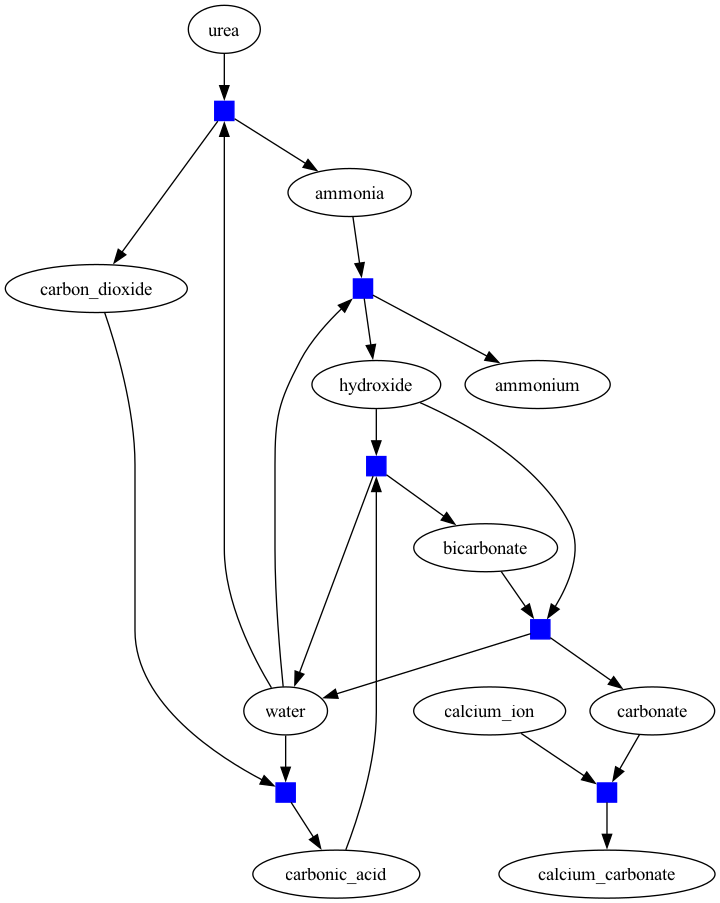

In [11]:
from mira.modeling.ode import OdeModel
from mira.modeling.viz import GraphicalModel

GraphicalModel.for_jupyter(mira_model)


In [12]:
model_json_file_name = 'microbial_induced_calcium_carbonate_precipitation_petri_net_model.json'
community_modeling.convert_MIRA_model_to_petrinet_AMRPetriNetModel(mira_model,model_json_file_name)

In [14]:
start_time = 0.0
end_time = 0.1
logging_step_size = 0.01
num_samples = 3

petrinet_results = pyciemss.sample(model_json_file_name, end_time, logging_step_size, num_samples, start_time=start_time)
display(petrinet_results['data'].head())
print(petrinet_results.keys())

,timepoint_id,sample_id,timepoint_unknown,persistent_k2f_param,persistent_k2r_param,persistent_k4f_param,persistent_k4r_param,persistent_k5f_param,persistent_k5r_param,persistent_k6f_param,...,ammonia_state,carbon_dioxide_state,water_state,ammonium_state,hydroxide_state,carbonic_acid_state,bicarbonate_state,carbonate_state,calcium_carbonate_state,calcium_ion_state
0,0,0,0.0,0.746476,0.424869,0.296431,0.528564,0.874755,0.83559,0.930521,...,0.000010,0.000010,55.000000,0.000010,1.000000e-07,0.000010,0.000010,1.000000e-05,0.000000e+00,0.136
1,1,0,0.01,0.746476,0.424869,0.296431,0.528564,0.874755,0.83559,0.930521,...,0.021242,0.326072,54.357319,0.308777,3.087745e-01,0.007886,0.000016,4.065060e-06,1.655268e-08,0.136
2,2,0,0.02,0.746476,0.424869,0.296431,0.528564,0.874755,0.83559,0.930521,...,0.011018,0.322175,54.343212,0.319001,3.189905e-01,0.015670,0.000028,1.717764e-06,2.318340e-08,0.136
3,3,0,0.03,0.746476,0.424869,0.296431,0.528564,0.874755,0.83559,0.930521,...,0.007480,0.318323,54.335842,0.322540,3.225130e-01,0.023357,0.000045,8.302786e-07,2.594176e-08,0.136
4,4,0,0.04,0.746476,0.424869,0.296431,0.528564,0.874755,0.83559,0.930521,...,0.005697,0.314517,54.330242,0.324322,3.242755e-01,0.030950,0.000066,5.457908e-07,2.730545e-08,0.136


dict_keys(['data', 'unprocessed_result', 'risk'])


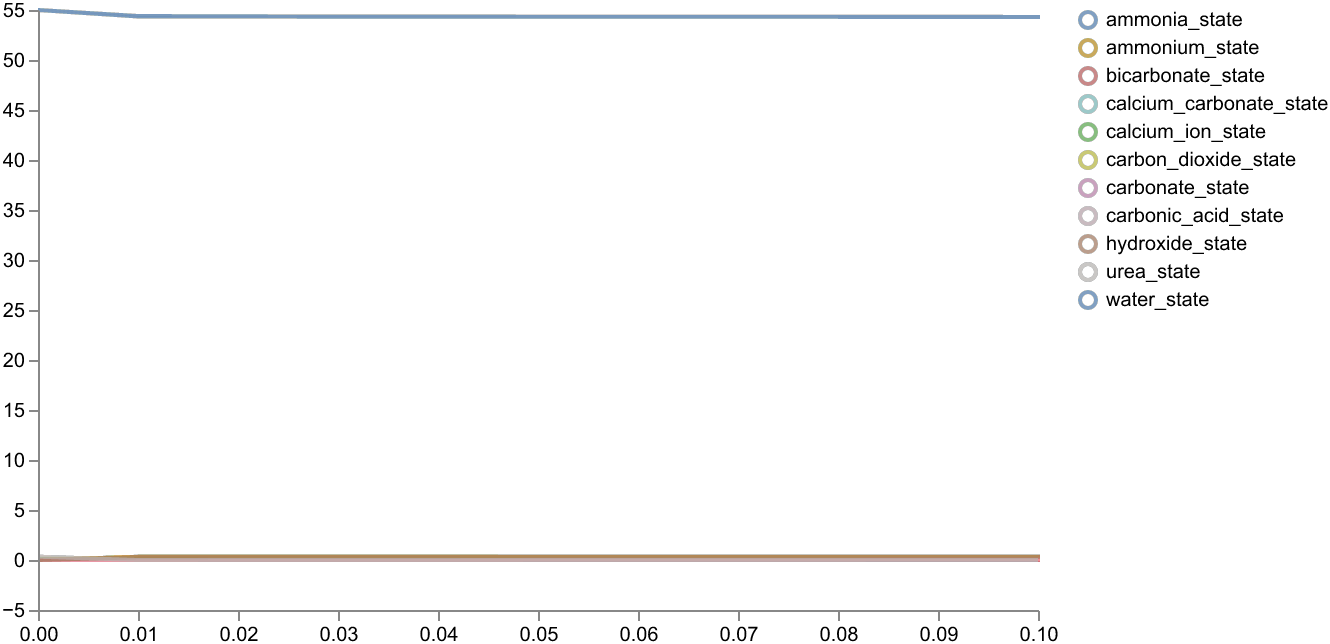

In [15]:
# Plot results for all states
schema = plots.trajectories(petrinet_results["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## FBA

getting 0 CaCO3 yield?!

In [16]:
import cobra



def save_sbml_to_cobra(sbml_file, cobra_filename):
    
    # Load the SBML model
    model = cobra.io.read_sbml_model(sbml_file)
    
    # Set metabolite compartment and name
    for metabolite in model.metabolites:
        metabolite.id = metabolite.name + "_e"
        metabolite.compartment = 'e'

    # Set boundary reactions
    model.add_boundary(model.metabolites.get_by_id('urea_e'), type='exchange')
    model.add_boundary(model.metabolites.get_by_id('ammonium_e'), type='exchange')
    model.add_boundary(model.metabolites.get_by_id('calcium_ion_e'), type='exchange')
    model.add_boundary(model.metabolites.get_by_id('calcium_carbonate_e'), type='exchange')

    # Set default bounds for all reactions
    for reaction in model.reactions:
        reaction.lower_bound = -1000
        reaction.upper_bound = 1000

    # Adjust bounds for specific reactions if needed
    model.reactions.get_by_id('reaction_ureolysis').lower_bound = 0   # Ureolysis is irreversible
    model.reactions.get_by_id('reaction_CO2_hydrolysis').lower_bound = 0   # CO2_hydrolysis is irreversible
    
    # Adjust bounds for boundary reactions
    model.reactions.get_by_id('EX_urea_e').lower_bound = -10
    model.reactions.get_by_id('EX_calcium_ion_e').lower_bound = -10
    model.reactions.get_by_id('EX_ammonium_e').upper_bound = 10
    model.reactions.get_by_id('EX_calcium_carbonate_e').upper_bound = 10

    # Set the objective to maximize CaCO3 production
    model.objective = 'reaction_CaCO3_precipitation'
    model.reactions.get_by_id('reaction_CaCO3_precipitation').objective_coefficient = 1
    
    cobra.io.write_sbml_model(model, filename=cobra_filename)


cobra_filename = 'microbial_induced_calcium_carbonate_precipitation_model_corrected_fba.xml'
save_sbml_to_cobra(corrected_sbml_file,cobra_filename)





Restricted license - for non-production use only - expires 2024-10-28


ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


In [17]:
model = cobra.io.read_sbml_model(cobra_filename)

# Perform FBA
solution = model.optimize()

# Print the objective value (max yield of CaCO3)
print("Objective value (CaCO3 yield):", solution.objective_value)

# Print the flux distribution
print("\nFlux distribution:")
for reaction in model.reactions:
    print(f"{reaction.id}: {solution.fluxes[reaction.id]}")



Objective value (CaCO3 yield): 5.0

Flux distribution:
EX_water: -10.0
reaction_ureolysis: 5.0
reaction_protonation_NH3: 5.0
reaction_CO2_hydrolysis: 5.0
reaction_dissociation_H2CO3: 5.0
reaction_dissociation_HCO3: 5.0
reaction_CaCO3_precipitation: 5.0
EX_urea_e: -5.0
EX_ammonium_e: 10.0
EX_calcium_ion_e: -5.0
EX_calcium_carbonate_e: 5.0


1 Mole of CaCO3 : 1 Mole of urea, calcuium ion, and calcium carbonate

1 Mole of CaCO3 : 2 Moles of ammonium and water